In [1]:
pip install deepxde


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 7.5 MB/s 
     |████████████████████████████████| 100 kB 10.6 MB/s 


In [13]:
# Analytical solution for scattering of a plane wave by a sound-hard circle,
# i.e., with the Neumann data set to zero on the circle boundary.
# Samuel Groth
# Cambridge, 20/11/19

import scipy
import numpy as np
from scipy.special import jv, hankel1


def sound_hard_circle(k, rad, plot_grid):
    x = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel()))
    points = x
    fem_xx = points[0, :]
    fem_xy = points[1, :]
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)
    npts = np.size(fem_xx, 0)
    a = rad

    n_terms = np.int(30 + (k * a)**1.01)
    k0 = k

    Nx = plot_grid.shape[1]
    Ny = plot_grid.shape[2]

    u_inc = np.exp(1j * k0 * fem_xx)
    n_int = np.where(r < a)
    u_inc[n_int] = 0.0
    u_plot = u_inc.reshape(Nx, Ny)

    u_sc = np.zeros((npts), dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        bessel_deriv = jv(n-1, k0*a) - n/(k0*a) * jv(n, k0*a)
        hankel_deriv = n/(k0*a)*hankel1(n, k0*a) - hankel1(n+1, k0*a)
        u_sc += -(1j)**(n) * (bessel_deriv/hankel_deriv) * hankel1(n, k0*r) * \
            np.exp(1j*n*theta)

    u_sc[n_int] = 0.0
    u_scat = u_sc.reshape(Nx, Ny)
    u_tot = u_scat + u_plot

    return u_tot

def sound_hard_circle_deepxde(k0, a, points):
    
    fem_xx = points[:, 0:1]
    fem_xy = points[:, 1:2]
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)
    npts = np.size(fem_xx, 0)
    n_terms = np.int(30 + (k0 * a)**1.01)

    u_sc = np.zeros((npts), dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        bessel_deriv = jv(n-1, k0*a) - n/(k0*a) * jv(n, k0*a)
        hankel_deriv = n/(k0*a)*hankel1(n, k0*a) - hankel1(n+1, k0*a)
        u_sc += (-(1j)**(n) * (bessel_deriv/hankel_deriv) * hankel1(n, k0*r) * \
            np.exp(1j*n*theta)).ravel()

    return u_sc



def sound_soft_circle(k, rad, plot_grid):
    # from pylab import find
    from scipy.special import jv, hankel1
    import numpy as np
    x = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel()))
    points = x
    fem_xx = points[0, :]
    fem_xy = points[1, :]
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)
    npts = np.size(fem_xx, 0)
    a = rad

    n_terms = np.int(30 + (k * a)**1.01)
    k0 = k

    Nx = plot_grid.shape[1]
    Ny = plot_grid.shape[2]

    u_inc = np.exp(1j * k0 * fem_xx)
    n_int = np.where(r < a)
    u_inc[n_int] = 0.0
    u_plot = u_inc.reshape(Nx, Ny)

    u_sc = np.zeros((npts), dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        u_sc += -(1j)**(n) * (jv(n, k0*a)/hankel1(n, k0*a)) * \
                hankel1(n, k0*r) * np.exp(1j*n*theta)

    u_sc[n_int] = 0.0
    u_scat = u_sc.reshape(Nx, Ny)
    u_tot = u_scat + u_plot

    return u_tot


def penetrable_circle(k0, k1, rad, plot_grid):
    # from pylab import find
    from scipy.special import jv, hankel1
    import numpy as np
    x = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel()))
    points = x
    fem_xx = points[0, :]
    fem_xy = points[1, :]
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)
    npts = np.size(fem_xx, 0)
    a = rad

    n_terms = np.max([100, np.int(55 + (k0 * a)**1.01)])

    Nx = plot_grid.shape[1]
    Ny = plot_grid.shape[2]

    u_inc = np.exp(1j * k0 * fem_xx)
    n_int = np.where(r < a)
    n_ext = np.where(r >= a)
    u_inc[n_int] = 0.0
    u_plot = u_inc.reshape(Nx, Ny)

    u_int = np.zeros(npts, dtype=np.complex128)
    u_ext = np.zeros(npts, dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        bessel_k0 = jv(n, k0 * rad)
        bessel_k1 = jv(n, k1 * rad)

        hankel_k0 = hankel1(n, k0 * rad)

        bessel_deriv_k0 = jv(n-1, k0 * rad) - n/(k0 * rad) * jv(n, k0 * rad)
        bessel_deriv_k1 = jv(n-1, k1 * rad) - n/(k1 * rad) * jv(n, k1 * rad)

        hankel_deriv_k0 = n/(k0 * rad) * hankel_k0 - hankel1(n+1, k0 * rad)

        a_n = (1j**n) * (k1 * bessel_deriv_k1 * bessel_k0 -
                         k0 * bessel_k1 * bessel_deriv_k0) / \
                        (k0 * hankel_deriv_k0 * bessel_k1 -
                         k1 * bessel_deriv_k1 * hankel_k0)
        b_n = (a_n * hankel_k0 + (1j**n) * bessel_k0) / bessel_k1

        u_ext += a_n * hankel1(n, k0 * r) * np.exp(1j * n * theta)
        u_int += b_n * jv(n, k1 * r) * np.exp(1j * n * theta)

    u_int[n_ext] = 0.0
    u_ext[n_int] = 0.0
    u_sc = u_int + u_ext
    u_scat = u_sc.reshape(Nx, Ny)
    u_tot = u_scat + u_plot

    return u_tot


def sphere_density_contrast(sizeParam, n, Nx, rho1, rho2, plot_grid, a):

    # freq = 1000
    Ny = Nx
    # Ny = 100
    c01 = 1000
    # sizeParam = 5
    # a = 1
    c02 = c01/n

    # Unit amplitude for incident plane wave
    # p_max = 1.

    k1 = sizeParam/a
    k2 = k1*n

    beta = rho1 * c01 / (rho2 * c02)

    # We want to have at least one wavelength
    # rGammaR = a  # a + wl_air
    Nterms = 100
    # dpml = 0

    # rGammaS = a
    # DomainR = rGammaR

    # Hack for VIE comparisons
    # dx = DomainR * 2 / Nx

    # xmin,xmax,ymin,ymax=[-DomainR+dx/2,DomainR-dx/2,
    #                      -DomainR+dx/2,DomainR-dx/2];
    # plot_grid = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j];

    points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(),
                        np.array([0]*plot_grid[0].size)))

    # plot_me = np.zeros(points.shape[1],dtype=np.complex128)

    x, y, z = points

    # sphere_interior = np.sqrt(points[0, :]**2 + points[1, :]**2 +
    #                           points[2, :]**2)
    # idx_exterior = (sphere_interior >= DomainR-dpml)

    fem_xx = points[0, :]
    fem_xy = points[1, :]
    # colors = np.random.rand(10)
    # plt.plot(fem_xx, fem_xy, 'ob')
    # plt.show()
    # area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
    npts = np.size(fem_xx, 0)

    # set the vector for number of terms:
    m = np.arange(Nterms+1)
    # set up vector for scattered field:
    p_s = np.zeros((npts, 1), dtype=np.complex128)
    # zz = np.zeros((npts, 1))
    # r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy + zz * zz)
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)

    # print('frequency = ', freq);
    # print('k(air) = ', k1);
    # print('k(water) =', k2);
    # Legendre polynomial terms
    P_m = np.zeros((Nterms+1, npts), dtype=np.complex128)
    for m in range(0, Nterms+1):  # I need to access all (N+1) places in the
        # vector P_m. This is why, the range goes from 0 to N+1
        for j in range(0, len(theta)):
            th = theta[j]
            # the legendre function does not work with vectors, so passing
            # each value from the vector theta:
            aa = scipy.special.lpmn(m, m, np.cos(th))
            P_m[m, j] = aa[0][0, m]

    # print('computing field for transmission problem..')
    for m in range(0, Nterms+1):
        j_m_k1a = scipy.special.spherical_jn(m, k1*a, False)
        y_m_k1a = scipy.special.spherical_yn(m, k1*a, False)
        j_m_k2a = scipy.special.spherical_jn(m, k2*a, False)
        # Derivative of spherical Bessel function
        j_m_k1a_prime = scipy.special.spherical_jn(m, k1*a, True)
        y_m_k1a_prime = scipy.special.spherical_yn(m, k1*a, True)
        j_m_k2a_prime = scipy.special.spherical_jn(m, k2*a, True)
        # Hankel function
        h_m_k1a = complex(j_m_k1a, -y_m_k1a)
        h_m_k1a_prime = complex(j_m_k1a_prime, -y_m_k1a_prime)
        D = (-1.+0.0j)**(1.-(m/2.)) * (2.*m+1.) / \
            (h_m_k1a_prime * j_m_k2a - beta * h_m_k1a * j_m_k2a_prime)
        A = (j_m_k2a * j_m_k1a_prime - beta * j_m_k1a * j_m_k2a_prime) * D
        B = (h_m_k1a * j_m_k1a_prime - h_m_k1a_prime * j_m_k1a) * D

        for ipt in range(0, len(fem_xx)):
            # radial distance from the center of sphere
            radius = np.sqrt(fem_xx[ipt]**2 + fem_xy[ipt]**2)
            if (radius >= a):
                j_m_k1r = scipy.special.spherical_jn(m, k1*radius, False)
                y_m_k1r = scipy.special.spherical_yn(m, k1*radius, False)
                # second kind spherical hankel function:
                h_m_k1r = complex(j_m_k1r, -y_m_k1r)
                p_s[ipt] += A * h_m_k1r * P_m[m, ipt]
            else:
                j_m_k2r = scipy.special.spherical_jn(m, k2*radius, False)
                p_s[ipt] += B * j_m_k2r * P_m[m, ipt]

    # set up incident field everywhere including the the interior of sphere:
    p_i = np.zeros((npts, 1), dtype=np.complex128)
    for j in range(0, npts):
        p_i[j] = np.exp(-1j*k1*fem_xx[j])
    # find the radius of each evaluation point from the center of sphere:
    r = np.sqrt(fem_xx**2 + fem_xy**2)
    # find which points lie in the interior of sphere:
    n_int = np.where(r < a)
    # set the incident field interior to sphere to be zero:
    p_i[n_int] = complex(0.0, 0.0)
    # add the resulting incident field to the scattered field computed before:
    p_t = p_s + p_i
    # p_t[idx_exterior] = 0.

    P = p_t.reshape((Nx, Ny))

    return P

Compiling model...
Building feed-forward neural network...
'build' took 0.077486 s



/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 2.150451 s

Initializing variables...
Training model...

0         [9.97e-01, 1.94e-01, 8.52e+01, 4.02e+01]    [8.88e-01, 1.93e-01, 8.52e+01, 4.02e+01]    [1.91e+00]    
1000      [4.46e-03, 3.54e-03, 1.34e-03, 1.08e-03]    [2.77e-03, 2.21e-03, 1.34e-03, 1.08e-03]    [1.78e+00]    
2000      [6.52e-04, 5.31e-04, 3.61e-04, 2.24e-04]    [3.95e-04, 3.50e-04, 3.61e-04, 2.24e-04]    [1.85e+00]    
3000      [2.48e-04, 2.21e-04, 2.11e-04, 1.95e-04]    [1.60e-04, 1.55e-04, 2.11e-04, 1.95e-04]    [1.86e+00]    
4000      [1.33e-04, 1.19e-04, 3.76e-03, 3.80e-03]    [1.27e-04, 1.21e-04, 3.76e-03, 3.80e-03]    [1.86e+00]    
5000      [5.62e-05, 5.36e-05, 2.79e-05, 4.14e-05]    [4.76e-05, 4.51e-05, 2.79e-05, 4.14e-05]    [1.84e+00]    
6000      [4.11e-05, 3.74e-05, 8.68e-06, 1.95e-05]    [3.58e-05, 3.38e-05, 8.68e-06, 1.95e-05]    [1.84e+00]    
7000      [2.96e-05, 2.83e-05, 5.06e-06, 1.29e-05]    [2.56e-05, 2.61e-05, 5.06e-06, 1.29e-05]    [1.83e+00]    
8000      [1.20e-04, 1.8

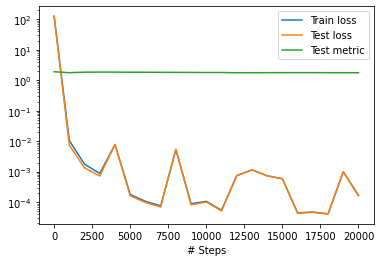

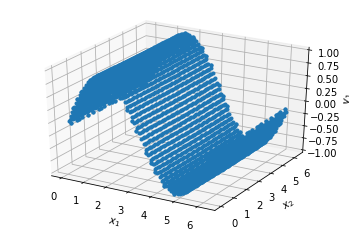

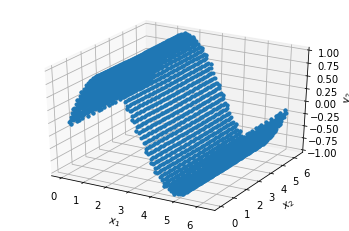

In [12]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np

# General parameters
n = 2
precision_train = 10
precision_test = 10
hard_constraint = True
weights = 100  # if hard_constraint == False
epochs = 20000 # tested with 50.000 epochs.
parameters = [1e-3, 4, 80, "sin"]

# learning rate
# depth
# width
# activation function

k0 = 1  

wave_len = 2*np.pi / k0  # wavelength

dim_x = 2 * np.pi
n_wave = 20

# The mesh element size is h_elem
h_elem = wave_len / n_wave

nx = int(dim_x / h_elem)

# Define sine function
if dde.backend.backend_name == "pytorch":
    cos = dde.backend.pytorch.cos
else:
    from deepxde.backend import tf

    cos = tf.cos

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters


def pde(x, y):
    yRe, yIm = y[:, 0:1], y[:, 1:2]
    
    
    dyRe_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    dyRe_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    dyIm_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dyIm_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    
    return [-dyRe_xx - dyRe_yy - k0 ** 2 * yRe,
            -dyIm_xx - dyIm_yy - k0 ** 2 * yIm]

def sol(x):
    return np.cos(k0 * x[:, 0:1])

def func(x):
    real = np.real(np.cos(k0 * x[:, 0:1]))
    imag = np.imag(np.cos(k0 * x[:, 0:1]))
    return np.hstack((real, imag))


def boundary(_, on_boundary):
    return on_boundary

def func0(x):
    normal = geom.boundary_normal(x)
    result = k0 * np.cos(k0 * x[:, 0:1]) * normal[:, 0:1]
    return(result)


geom = dde.geometry.Rectangle([0, 0], [dim_x, dim_x])


bcRe = dde.icbc.NeumannBC(geom, func0, boundary, component=0)
bcIm = dde.icbc.NeumannBC(geom, func0, boundary, component=1)

bcs = [bcRe, bcIm]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx ** 2,
    num_boundary=4 * nx,
    solution=func,
    num_test=10 * nx ** 2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)

model = dde.Model(data, net)
loss_weights = [1, 1, weights, weights]
model.compile(
    "adam", lr=learning_rate, metrics=["l2 relative error"], 
    loss_weights=loss_weights
)


losshistory, train_state = model.train(epochs=epochs)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Relative error =  1.670434165551678


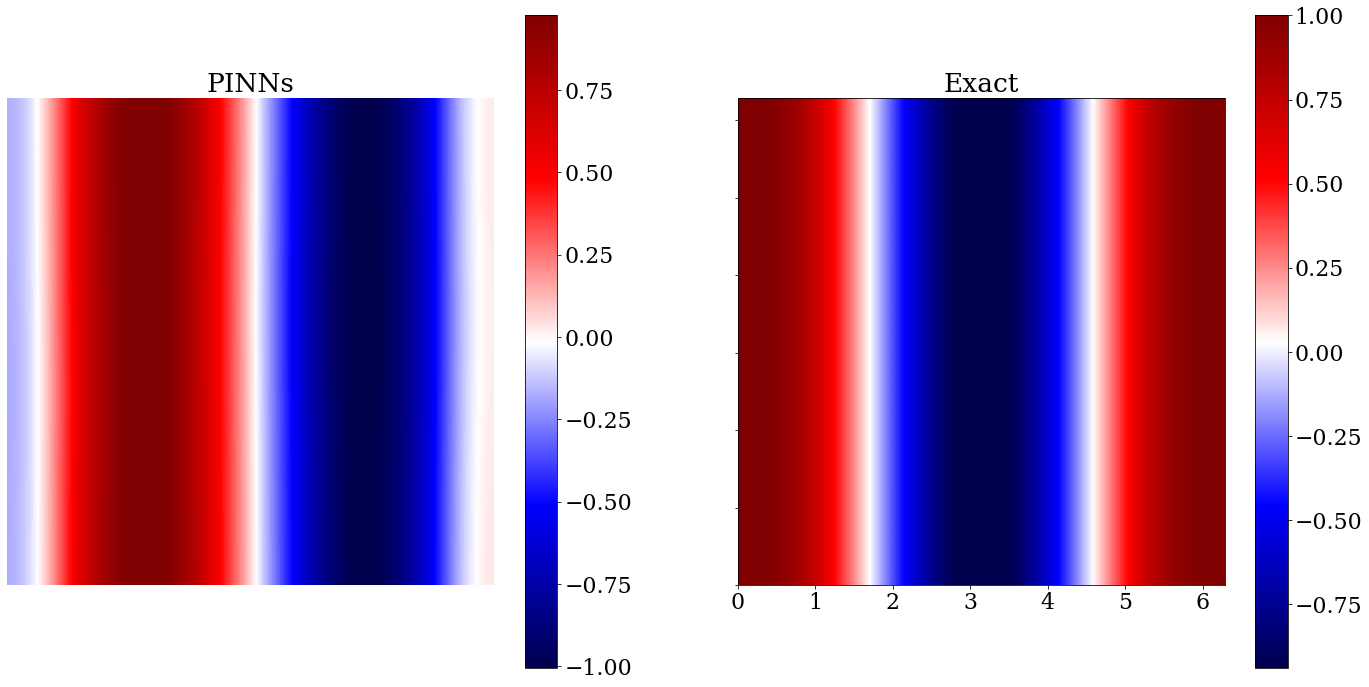

In [14]:
import matplotlib.pyplot as plt
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(dim_x/wave_len * 10))
Ny = Nx


# Grid points
xmin, xmax, ymin, ymax = [0, dim_x, 0, dim_x]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

#in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
#in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
#points[0, in_circ] = -radius - wave_len / 10
#points[1, in_circ] = radius + wave_len / 10
#points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations

u_sca = model.predict(points[:2, :].T)
u_sca = u_sca[:, 0] + 1j* u_sca[:, 1]
u_sca = u_sca.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run

u_exact = sol(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact-u_sca
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.real(u_sca)).T,
           extent=[0,dim_x,0,dim_x],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')

ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.real(u_exact)).T,
           extent=[0,dim_x,0,dim_x],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')


#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)